# Import Darts


In [ ]:
!pip install darts

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [ ]:
path = "/content/"
filename = "BTC_USD-5m.json"

raw_data = pd.read_json(path + filename)
raw_data = raw_data.rename(columns = {0 : 'Timestamp', 1 : 'Open', 2 : 'High', 3 : 'Low', 4 : 'Close', 5 : 'Volume'})
raw_data["Timestamp"] = pd.to_datetime(raw_data["Timestamp"],
    unit="ms")
raw_data = raw_data.set_index('Timestamp')
raw_data["Return"] = raw_data.Close.pct_change(1).mul(100)
raw_data["Volatility"] = raw_data.Return.abs()
raw_data = raw_data.dropna(axis=0)

raw_data["Volume_Adjusted"] = raw_data[["High", "Low"]].mean(axis=1) * raw_data['Volume']
raw_data.tail(5)


,Open,High,Low,Close,Volume,Return,Volatility,Volume_Adjusted
Timestamp,,,,,,,,
2022-01-15 10:30:00,43226.39,43226.39,43161.39,43196.51,0.118631,-0.078117,0.078117,5124.134365
2022-01-15 10:35:00,43187.79,43197.61,43183.08,43185.86,0.045296,-0.024655,0.024655,1956.349867
2022-01-15 10:40:00,43186.99,43186.99,43128.15,43167.18,1.371765,-0.043255,0.043255,59202.044011
2022-01-15 10:45:00,43171.43,43178.60,43151.19,43155.55,0.065927,-0.026942,0.026942,2845.732033
2022-01-15 10:50:00,43156.69,43156.69,43128.80,43144.10,0.196828,-0.026532,0.026532,8491.700213


In [ ]:
filename2 = "BTC_USD-5mtest.json"

raw_data2 = pd.read_json(path + filename2)
raw_data2 = raw_data2.rename(columns = {0 : 'Timestamp', 1 : 'Open', 2 : 'High', 3 : 'Low', 4 : 'Close', 5 : 'Volume'})
raw_data2["Timestamp"] = pd.to_datetime(raw_data2["Timestamp"],
    unit="ms")
raw_data2 = raw_data2.set_index('Timestamp')
raw_data2["Return"] = raw_data2.Close.pct_change(1).mul(100)
raw_data2["Volatility"] = raw_data2.Return.abs()
raw_data2 = raw_data2.dropna(axis=0)

raw_data2["Volume_Adjusted"] = raw_data2[["High", "Low"]].mean(axis=1) * raw_data2['Volume']
raw_data2.head(5)

,Open,High,Low,Close,Volume,Return,Volatility,Volume_Adjusted
Timestamp,,,,,,,,
2022-01-19 00:05:00,42300.18,42345.15,42300.11,42302.12,0.417022,-0.022405,0.022405,17649.467808
2022-01-19 00:10:00,42300.00,42321.49,42269.78,42310.00,0.877062,0.018628,0.018628,37095.894224
2022-01-19 00:15:00,42315.12,42322.88,42263.81,42272.53,2.737451,-0.088561,0.088561,115775.959564
2022-01-19 00:20:00,42269.20,42349.62,42269.20,42331.11,1.794177,0.138577,0.138577,75910.570306
2022-01-19 00:25:00,42340.73,42489.79,42333.17,42476.04,3.182283,0.342372,0.342372,134965.331809


In [ ]:
filler = MissingValuesFiller()
scaler = Scaler()
timeseries = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_series(
            raw_data["Close"], fill_missing_dates=True, freq=None
        )
    )
).astype(np.float32)

train, val = timeseries.split_after(pd.Timestamp("2021-01-01 00:00:00"))


In [ ]:
filler = MissingValuesFiller()
scaler = Scaler()
testseries = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_series(
            raw_data2["Close"], fill_missing_dates=True, freq=None
        )
    )
).astype(np.float32)


In [ ]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
    torch_device_str="cuda:0"
)


In [ ]:
model_nbeats.fit(train, val_series=val, verbose=True)

[2022-01-29 22:22:39,478] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 101058 samples.
[2022-01-29 22:22:39,478] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 101058 samples.
[2022-01-29 22:22:39,572] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-01-29 22:22:39,572] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
  1%|          | 1/100 [00:44<1:13:56, 44.81s/it]

  2%|▏         | 2/100 [01:27<1:10:57, 43.44s/it]

  3%|▎         | 3/100 [02:09<1:09:35, 43.05s/it]

  4%|▍         | 4/100 [02:52<1:08:36, 42.88s/it]

  5%|▌         | 5/100 [03:35<1:07:40, 42.75s/it]

  6%|▌         | 6/100 [04:17<1:06:49, 42.65s/it]

  7%|▋         | 7/100 [05:00<1:06:04, 42.63s/it]

  8%|▊         | 8/100 [05:42<1:05:15, 42.56s/it]

  9%|▉         | 9/100 [06:25<1:04:35, 42.59s/it]

 10%|█         | 10/100 [07:07<1:03:52, 42.58s/it]

 11%|█         | 11/100 [07:50<1:03:16, 42.66s/it]

 12%|█▏        | 12/100 [08:33<1:02:31, 42.63s/it]

 13%|█▎        | 13/100 [09:16<1:02:00, 42.77s/it]

 14%|█▍        | 14/100 [09:59<1:01:21, 42.81s/it]

 15%|█▌        | 15/100 [10:42<1:00:42, 42.85s/it]

 16%|█▌        | 16/100 [11:24<1:00:01, 42.87s/it]

 17%|█▋        | 17/100 [12:07<59:21, 42.91s/it]  

 18%|█▊        | 18/100 [12:51<58:44, 42.98s/it]

 19%|█▉        | 19/100 [13:34<58:00, 42.98s/it]

 20%|██        | 20/100 [14:17<57:23, 43.04s/it]

 21%|██        | 21/100 [15:00<56:40, 43.05s/it]

 22%|██▏       | 22/100 [15:43<55:52, 42.98s/it]

 23%|██▎       | 23/100 [16:26<55:15, 43.06s/it]

 24%|██▍       | 24/100 [17:09<54:27, 43.00s/it]

 25%|██▌       | 25/100 [17:52<53:44, 43.00s/it]

 26%|██▌       | 26/100 [18:35<53:00, 42.98s/it]

 27%|██▋       | 27/100 [19:18<52:16, 42.96s/it]

 28%|██▊       | 28/100 [20:01<51:32, 42.96s/it]

 29%|██▉       | 29/100 [20:43<50:44, 42.88s/it]

 30%|███       | 30/100 [21:26<50:03, 42.90s/it]

 31%|███       | 31/100 [22:09<49:19, 42.89s/it]

 32%|███▏      | 32/100 [22:52<48:34, 42.86s/it]

 33%|███▎      | 33/100 [23:35<47:51, 42.86s/it]

 34%|███▍      | 34/100 [24:18<47:11, 42.89s/it]

 35%|███▌      | 35/100 [25:01<46:28, 42.90s/it]

 36%|███▌      | 36/100 [25:43<45:42, 42.86s/it]

 37%|███▋      | 37/100 [26:26<45:00, 42.86s/it]

 38%|███▊      | 38/100 [27:09<44:14, 42.81s/it]

 39%|███▉      | 39/100 [27:52<43:32, 42.83s/it]

 40%|████      | 40/100 [28:35<42:53, 42.89s/it]

 41%|████      | 41/100 [29:18<42:11, 42.91s/it]

 42%|████▏     | 42/100 [30:01<41:35, 43.02s/it]

 43%|████▎     | 43/100 [30:44<40:49, 42.97s/it]

 44%|████▍     | 44/100 [31:26<39:57, 42.82s/it]

 45%|████▌     | 45/100 [32:09<39:12, 42.77s/it]

 46%|████▌     | 46/100 [32:51<38:23, 42.66s/it]

 47%|████▋     | 47/100 [33:34<37:36, 42.57s/it]

 48%|████▊     | 48/100 [34:16<36:49, 42.50s/it]

 49%|████▉     | 49/100 [34:58<36:03, 42.42s/it]

 50%|█████     | 50/100 [35:41<35:18, 42.37s/it]

 51%|█████     | 51/100 [36:23<34:31, 42.29s/it]

 52%|█████▏    | 52/100 [37:05<33:50, 42.30s/it]

 53%|█████▎    | 53/100 [37:47<33:04, 42.23s/it]

 54%|█████▍    | 54/100 [38:30<32:24, 42.28s/it]

 55%|█████▌    | 55/100 [39:12<31:43, 42.31s/it]

 56%|█████▌    | 56/100 [39:54<31:02, 42.33s/it]

 57%|█████▋    | 57/100 [40:37<30:19, 42.31s/it]

 58%|█████▊    | 58/100 [41:19<29:36, 42.30s/it]

 59%|█████▉    | 59/100 [42:01<28:51, 42.24s/it]

 60%|██████    | 60/100 [42:43<28:08, 42.22s/it]

 61%|██████    | 61/100 [43:25<27:27, 42.25s/it]

 62%|██████▏   | 62/100 [44:08<26:46, 42.27s/it]

 63%|██████▎   | 63/100 [44:50<26:02, 42.23s/it]

 64%|██████▍   | 64/100 [45:32<25:22, 42.29s/it]

 65%|██████▌   | 65/100 [46:15<24:39, 42.28s/it]

 66%|██████▌   | 66/100 [46:57<23:58, 42.32s/it]

 67%|██████▋   | 67/100 [47:39<23:16, 42.30s/it]

 68%|██████▊   | 68/100 [48:21<22:33, 42.29s/it]

 69%|██████▉   | 69/100 [49:04<21:53, 42.36s/it]

 70%|███████   | 70/100 [49:46<21:08, 42.29s/it]

 71%|███████   | 71/100 [50:29<20:28, 42.36s/it]

 72%|███████▏  | 72/100 [51:12<19:52, 42.59s/it]

 73%|███████▎  | 73/100 [51:54<19:09, 42.58s/it]

 74%|███████▍  | 74/100 [52:37<18:25, 42.52s/it]

 75%|███████▌  | 75/100 [53:19<17:40, 42.42s/it]

 76%|███████▌  | 76/100 [54:01<16:57, 42.41s/it]

 77%|███████▋  | 77/100 [54:44<16:14, 42.38s/it]

 78%|███████▊  | 78/100 [55:26<15:32, 42.40s/it]

 79%|███████▉  | 79/100 [56:08<14:50, 42.39s/it]

 80%|████████  | 80/100 [56:51<14:07, 42.39s/it]

 81%|████████  | 81/100 [57:33<13:25, 42.40s/it]

 82%|████████▏ | 82/100 [58:15<12:42, 42.35s/it]

 83%|████████▎ | 83/100 [58:58<12:00, 42.38s/it]

 84%|████████▍ | 84/100 [59:41<11:19, 42.48s/it]

 85%|████████▌ | 85/100 [1:00:23<10:36, 42.42s/it]

 86%|████████▌ | 86/100 [1:01:05<09:53, 42.42s/it]

 87%|████████▋ | 87/100 [1:01:48<09:13, 42.54s/it]

 88%|████████▊ | 88/100 [1:02:31<08:31, 42.62s/it]

 89%|████████▉ | 89/100 [1:03:13<07:48, 42.58s/it]

 90%|█████████ | 90/100 [1:03:56<07:05, 42.56s/it]

 91%|█████████ | 91/100 [1:04:38<06:22, 42.55s/it]

 92%|█████████▏| 92/100 [1:05:21<05:40, 42.58s/it]

 93%|█████████▎| 93/100 [1:06:04<04:58, 42.63s/it]

 94%|█████████▍| 94/100 [1:06:47<04:15, 42.63s/it]

 95%|█████████▌| 95/100 [1:07:29<03:32, 42.55s/it]

 96%|█████████▌| 96/100 [1:08:11<02:50, 42.51s/it]

 97%|█████████▋| 97/100 [1:08:54<02:07, 42.49s/it]

 98%|█████████▊| 98/100 [1:09:37<01:25, 42.61s/it]

 99%|█████████▉| 99/100 [1:10:20<00:42, 42.80s/it]

100%|██████████| 100/100 [1:11:03<00:00, 42.64s/it]

In [ ]:
model_nbeats.save_model("/content/NBEATClose.pth.tar")

In [ ]:
model_nbeats.predict(2, verbose=True)

100%|██████████| 1/1 [00:00<00:00, 39.72it/s]


<TimeSeries (DataArray) (time: 2, component: 1, sample: 1)>
array([[[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01T00:05:00 2021-01-01T00:10:00
  * component  (component) object 'Open'
Dimensions without coordinates: sample

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    testseries,
    start=pd.Timestamp("2022-01-29 12:05:00"),
    forecast_horizon=1,
    retrain=False,
    verbose=True,
)


100%|██████████| 145/145 [00:02<00:00, 60.30it/s]


In [ ]:
pred_series.tail(5)

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[0.4800521 ]],

       [[0.48042637]],

       [[0.48023254]],

       [[0.4809911 ]],

       [[0.48068964]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-29T23:45:00 ... 2022-01-30T00:05:00
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

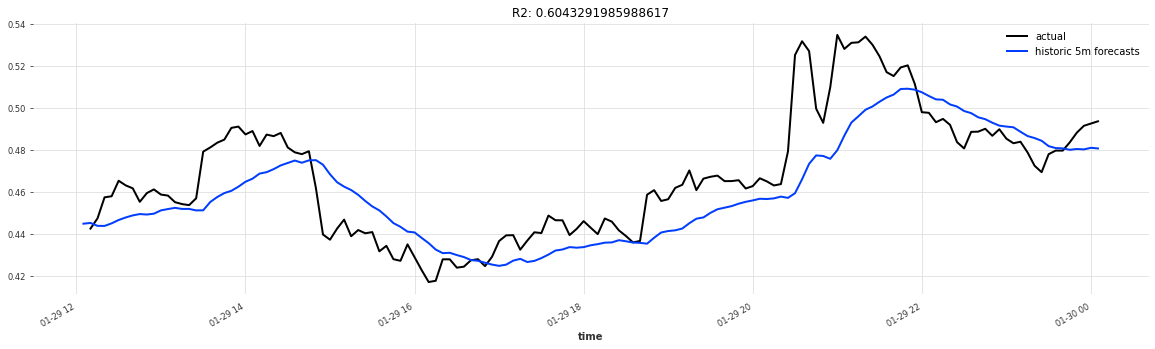

In [ ]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(20, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

display_forecast(pred_series, testseries, "5m", start_date=pd.Timestamp("2022-01-29 12:05:00"))